In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import load_logging_data, create_lstm_dataset
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [2]:
dataset = load_logging_data(data_root_path='data')

Loading data...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
angle_name_list = list(dataset.columns)[22:24] + list(dataset.columns)[26:28]

for angle_name in angle_name_list:
    dataset = dataset[dataset[angle_name] < 5]

for angle_name in angle_name_list:
    dataset = dataset[dataset[angle_name] > -5]

dataset.reset_index(drop=True, inplace=True)

In [4]:
pressure_name_list = list(dataset.columns)[18:20] + list(dataset.columns)[24:26]

for pressure_name in pressure_name_list:
    dataset = dataset[dataset[pressure_name] > 0]

dataset.reset_index(drop=True, inplace=True)

In [5]:
dataset = dataset[dataset['caloutput_drill_depth CH=26'] > 3]
dataset.reset_index(drop=True, inplace=True)

In [6]:
dataset = dataset[dataset['caloutput_rotate_velocity CH=25'] > 0]
dataset.reset_index(drop=True, inplace=True)

In [7]:
dataset['power'] = dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] * dataset['caloutput_rotate_velocity CH=25']
dataset['power'] = (dataset['power']-dataset['power'].min()) / (dataset['power'].max()-dataset['power'].min())

In [8]:
extract_data = dataset[angle_name_list+['caloutput_drill_depth CH=26', 'power']].to_numpy()

grad_data_list = list()

for data in extract_data.T:
    grad_data_list.append(np.gradient(data))

grad_data_arr = np.array(grad_data_list).T
extract_data = np.concatenate([extract_data, grad_data_arr], axis=1)

In [9]:
seq_len = 30
pred_distance = 20
hidden_size = 500
n_output = 1

feature, target = create_lstm_dataset(extract_data, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=5)

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, verbose=0)
csv_logger = keras.callbacks.CSVLogger('log.csv', append=True, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath='lstm_model.keras', monitor="val_loss", verbose=0, save_best_only=True,
                                                  save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


def lstm_est_model():
    input_tensor = keras.layers.Input(shape=(seq_len, feature.shape[2]), dtype=tf.float32)
    input_flatten_layer = keras.layers.Flatten()(input_tensor)

    mean_tensor = tf.reduce_mean(input_tensor, axis=1)
    max_tensor = tf.reduce_max(input_tensor, axis=1)
    min_tensor = tf.reduce_min(input_tensor, axis=1)
    sum_tensor = tf.reduce_sum(input_tensor, axis=1)
    std_tensor = tf.math.reduce_std(input_tensor, axis=1)

    avg_low_bool = tf.less(input_tensor, tf.expand_dims(mean_tensor, axis=1))
    avg_low_count = tf.math.count_nonzero(avg_low_bool, axis=1, dtype=tf.float32)
    avg_high_count = tf.math.count_nonzero(tf.math.logical_not(avg_low_bool), axis=1, dtype=tf.float32)
    
    feature_eng_tensor = keras.layers.concatenate([mean_tensor, max_tensor, min_tensor, sum_tensor, std_tensor, avg_low_count, avg_high_count])

    # Convolutional Layers
    conv_layer = keras.layers.Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(input_tensor)
    
    conv_layer = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_layer = keras.layers.MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_flatten_layer = keras.layers.Flatten()(conv_layer)

    # LSTM Layers
    lstm_output_1 = keras.layers.LSTM(units=hidden_size, return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.03), name='lstm_1')(conv_layer)
    lstm_output_2 = keras.layers.LSTM(units=hidden_size, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.03), name='lstm_2')(conv_layer)
    lstm_output_2 = keras.layers.LSTM(units=int(hidden_size/2), return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.03), name='lstm_3')(lstm_output_2)
    
    # Concatenation of all features
    concat_tensor = keras.layers.concatenate([input_flatten_layer, conv_flatten_layer, lstm_output_1, lstm_output_2, feature_eng_tensor], axis=-1)

    # Output Layer
    output_tensor = keras.layers.Dense(n_output, activation='linear')(concat_tensor)

    # Model Compilation
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

    return model

In [11]:
lstm_model = lstm_est_model()
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 12)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 64)       5440        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 128)      41088       ['conv1d[0][0]']                 
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (None, 12)          0           ['input_1[0][0]']                
 a)                                                                                           

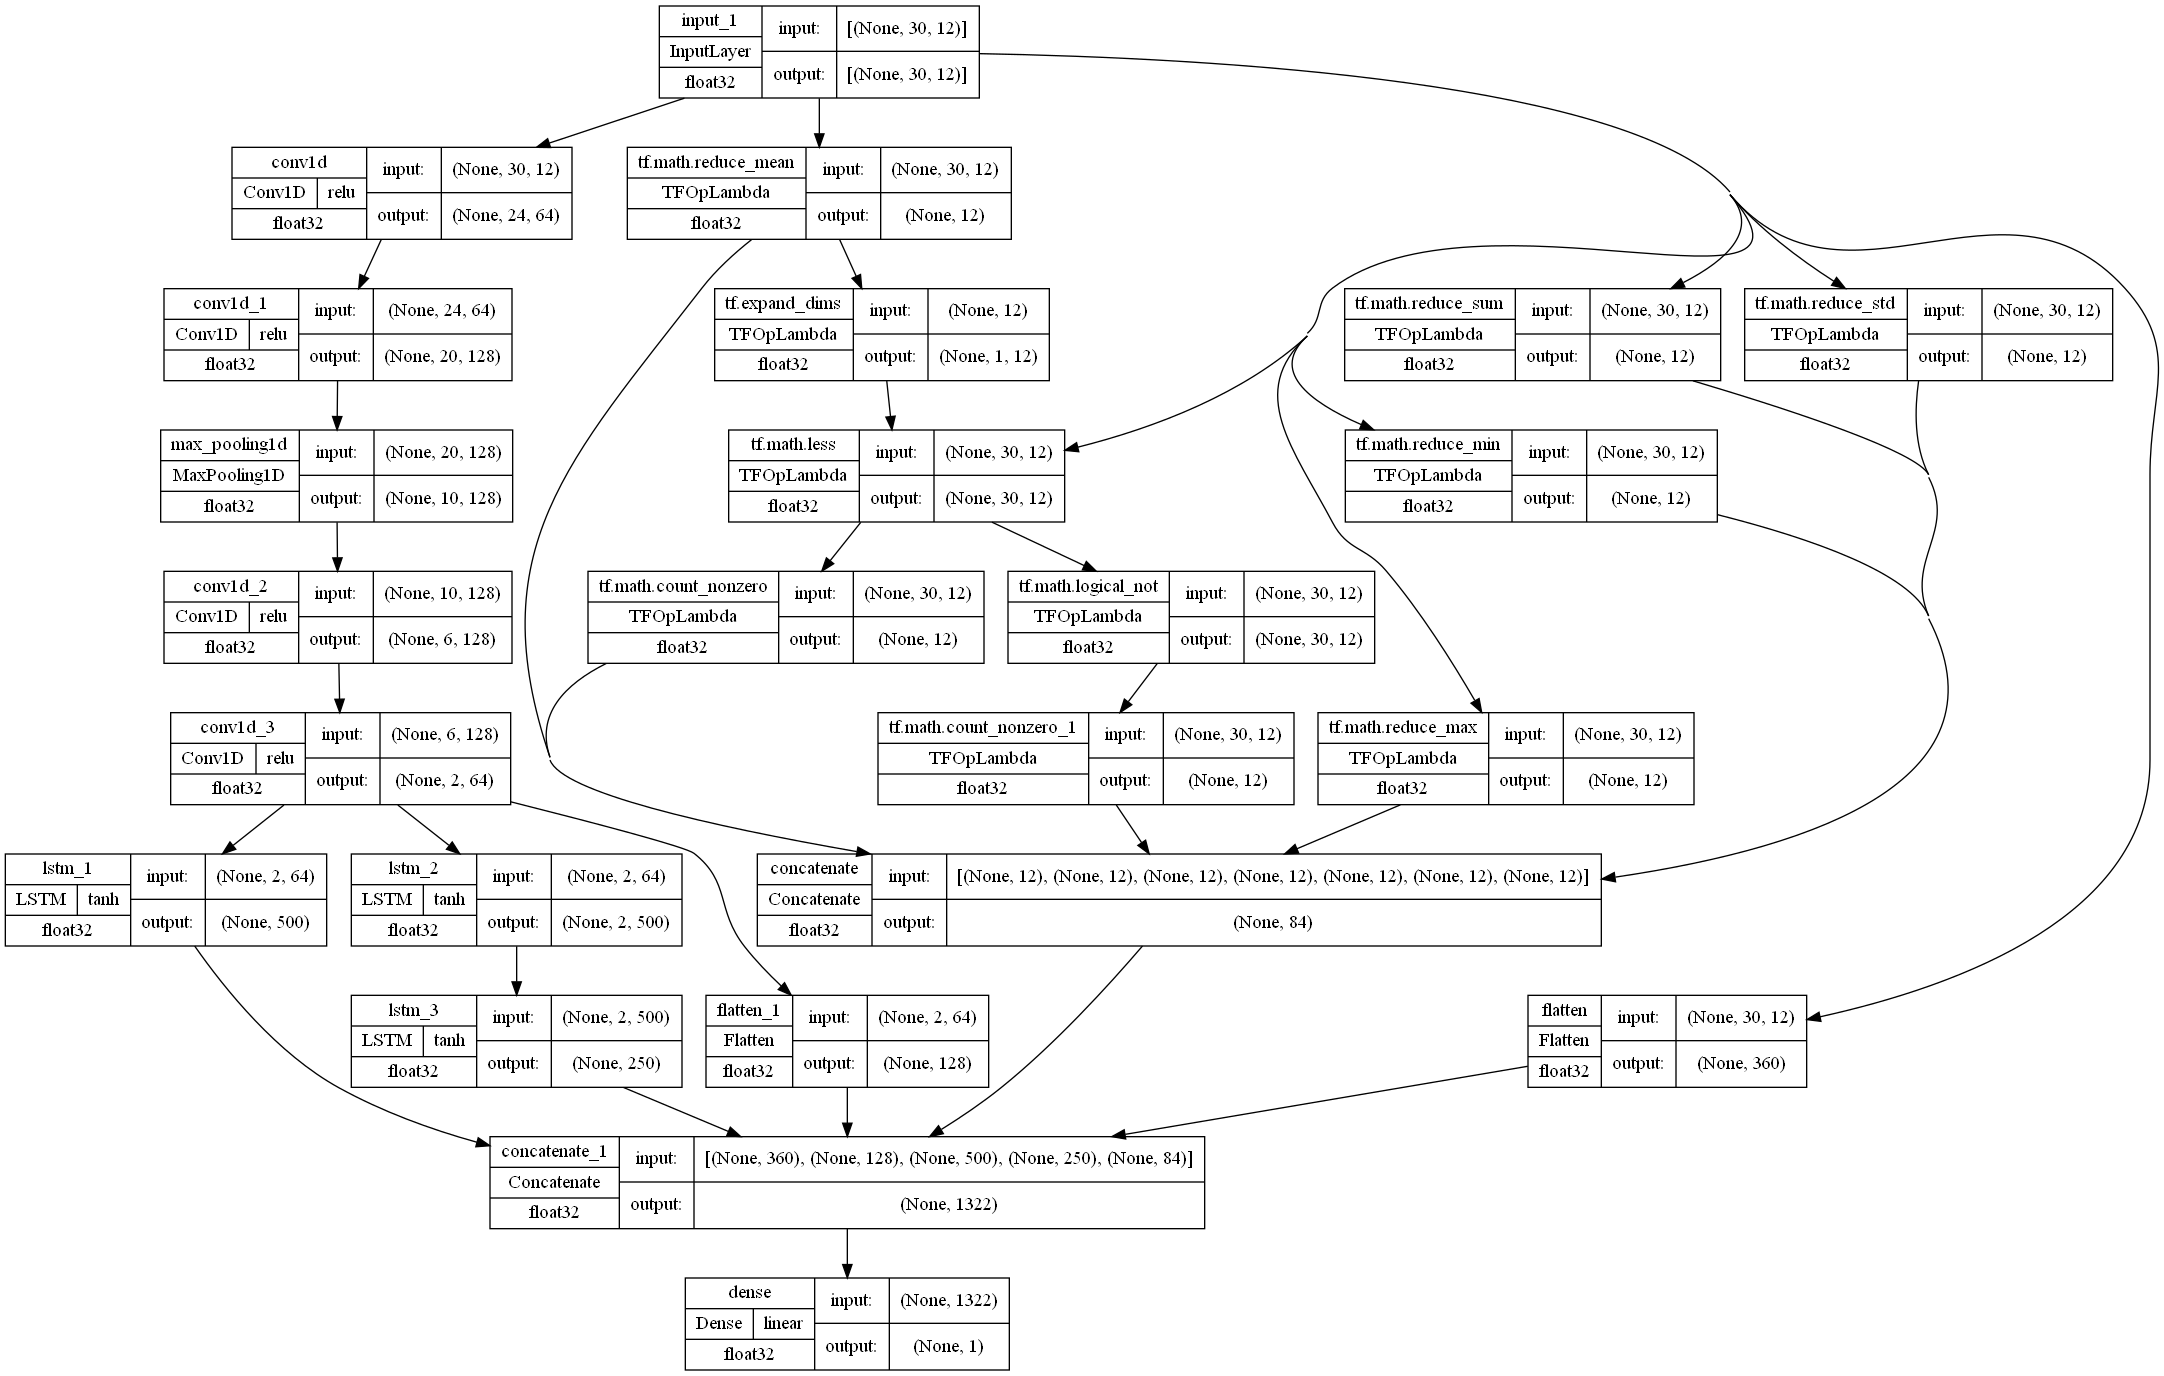

In [12]:
keras.utils.plot_model(lstm_model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [13]:
model_history = lstm_model.fit(x=feature, y=target, validation_data=(feature, target), epochs=1000000, 
                               batch_size=10000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point, tensorboard_callback])

In [14]:
best_lstm_model = keras.models.load_model('lstm_model.keras')

In [15]:
pred = np.squeeze(best_lstm_model.predict(feature, verbose=1))

83/83 [==============================] - 2s 6ms/step


In [16]:
print(r2_score(target, pred)) 
print(mean_absolute_error(target, pred)) 
print(mean_absolute_percentage_error(target, pred))

0.9004168700341811
0.05646940143228003
1094444921308.0112


In [17]:
train_loss_list = model_history.history['loss']

train_mean_abs_loss_list = model_history.history['mean_absolute_error']

train_mean_abs_per_loss_list = model_history.history['mean_absolute_percentage_error']

Text(0, 0.5, 'Loss')

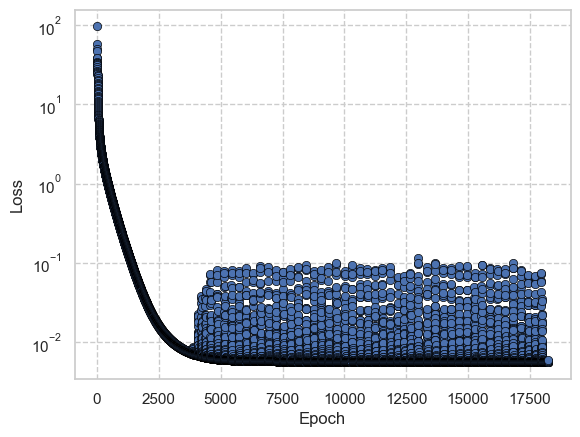

In [23]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(train_loss_list)), y=train_loss_list, edgecolor='black')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend(['Train Loss', 'Validation Loss'])

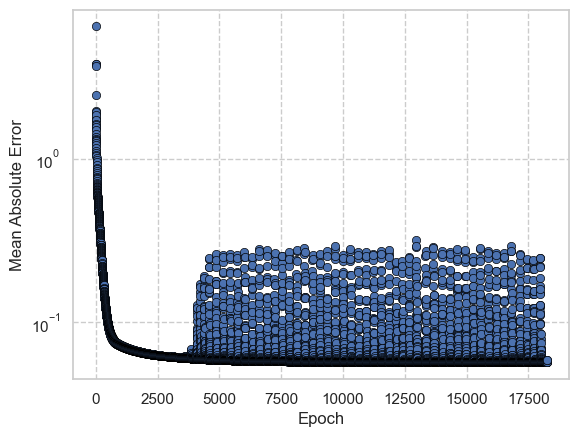

In [22]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(train_mean_abs_loss_list)), y=train_mean_abs_loss_list, edgecolor='black')

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.yscale('log')
#plt.legend(['Train Loss', 'Validation Loss'])

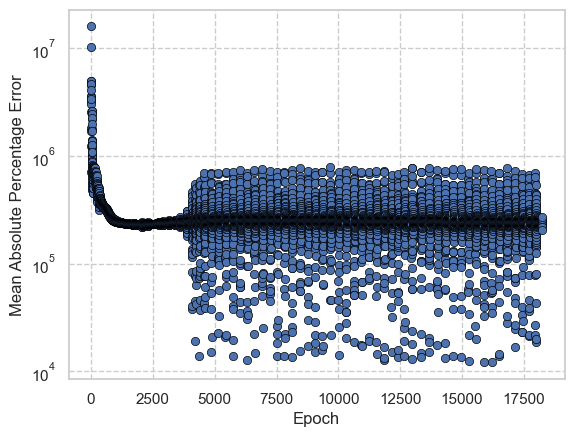

In [24]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(train_mean_abs_per_loss_list)), y=train_mean_abs_per_loss_list, edgecolor='black')

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Percentage Error')
plt.yscale('log')
#plt.legend(['Train Loss', 'Validation Loss'])

<Axes: >

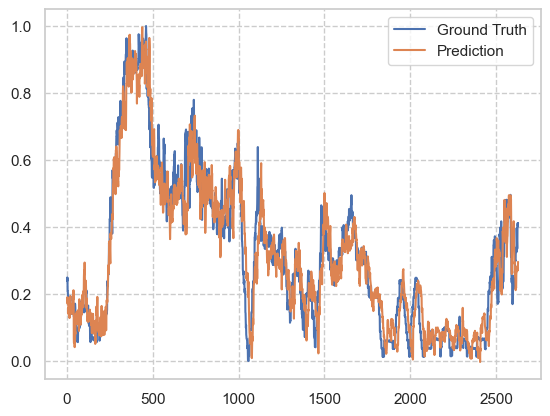

In [29]:
sns.lineplot(target, label='Ground Truth')
sns.lineplot(pred, label='Prediction')


In [43]:
target_1 = target[target != 0]
pred_1 = pred[target != 0]

error = np.abs(target_1-pred_1)/target_1*100

81.99247457651421

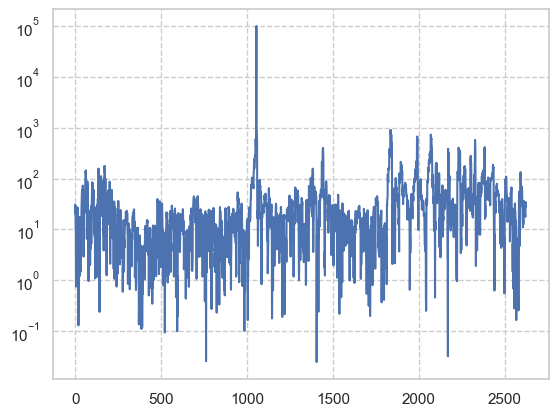

In [46]:
sns.lineplot(error)

plt.yscale('log')

np.mean(error)